# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

%matplotlib inline
pd.set_option('display.max_columns', None)


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Project Statement and Problem Definition

The goal of this project is to find an approperate offer for a starbucks customer based on their purchase behavior and response to the offers that sent previously. The customers receive different offer messages, and their responses was captured during 30 days which are provided by Starbucks.

To reach this goal, I can build a machine learning model that could predict whether a customer have high probability to complete an offer. The conclusion of this project may help Starbucks to find out several target groups could have a positive reaction towards some certain offers. The most relavent features may include: income, gender, age , platform, device, offer message and type. some of those features may have higher weight than others.

The problem can be simply to a binary classification problem. the model will predict whether a certain customer would more likely to complete an offer based on their profiles. And metric of the problem also need to be considerated. It can be simplify to an overall accuracy, f1_score and precision of the model.  

The problem is a real-word problem, and the solution of this problem may tolerate sending offer to some customer may not reponse, but does not expect avoid any customer may response. That means False Negatives is more important than False Positive. Moreover the dataset may include imbalanced classes data. in this case, F1-score is more fit to be used as metric of machine learning selection.

# 2. Data Cleaning


Each dataset will be cleaned seperatly.

## 2.1 Portfolio
### 2.1.1 overview of portfolio data
Firstly, Look at protfolio data head and describe. Then have a overview of data in the dataset

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


check the data distribution first.

In [3]:
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0


**analysis**: portfolio data has only 10 rows. a channels column which is a list of channel. For Machine learning purpose, each column to represent one feature is helpful to know the relevance of a feature to learning result. It is necessary to split list column to several feature columns. Similar idea fo offer type, each type can be a new feature column in dataset.

- Firstly, I find the command to split offer and channels to corresponding dummies.

- Secondly, create a method to clean the portfolio

In [4]:
offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
offer_dummies.head()

,offer_bogo,offer_discount,offer_informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [5]:
channels_dummies = portfolio['channels'].str.join(sep = ',').str.get_dummies(sep = ',').add_prefix('channel_')
channels_dummies.head()

,channel_email,channel_mobile,channel_social,channel_web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


### 2.1.2 clean the  portfolio data
### Here are the process to clean *portfolio.json*

1. clone original data 
2. Create dummies for the channels to channels_* columns
3. Create dummies for the offer to type_* columns
4. reorder the cloned dataset
5. concat dummies to new cloned dataset
6. reindex result dataset 

In [6]:
def clean_portfolio(portfolio_df = portfolio):
    '''
    Args:
        portfolio_df: DataFrame of portfolio

    Returns:
        df: Cleaned DataFrame of portfolio
    '''

    #make copy of data
    df = portfolio_df.copy()
    #create channels_dummies and offer_dummies
    channels_dummies = df['channels'].str.join(sep = ',').str.get_dummies(sep = ',').add_prefix('channel_')
    offer_dummies = pd.get_dummies(df['offer_type'], prefix = 'offer')
    offer_index = pd.Series(range(0,10), name='offer_index')
#     df = df.drop(['channels', 'offer_type'], axis = 1)

    df = df.rename(columns = {'id': 'offer_id'})
    columns_order = [ 'offer_id', 'reward', 'difficulty', 'duration', 'channels', 'offer_type']
    df = df.reindex(columns = columns_order)
    df = pd.concat([offer_index, df, channels_dummies, offer_dummies], axis = 1)
    df = df.reset_index(drop=True)
    df['channels_str'] = df['channels'].str.join(sep = '_')
    return df

In [7]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,offer_index,offer_id,reward,difficulty,duration,channels,offer_type,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,channels_str
0,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,"[email, mobile, social]",bogo,1,1,1,0,1,0,0,email_mobile_social
1,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,"[web, email, mobile, social]",bogo,1,1,1,1,1,0,0,web_email_mobile_social
2,2,3f207df678b143eea3cee63160fa8bed,0,0,4,"[web, email, mobile]",informational,1,1,0,1,0,0,1,web_email_mobile
3,3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,"[web, email, mobile]",bogo,1,1,0,1,1,0,0,web_email_mobile
4,4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,"[web, email]",discount,1,0,0,1,0,1,0,web_email
5,5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,"[web, email, mobile, social]",discount,1,1,1,1,0,1,0,web_email_mobile_social
6,6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,"[web, email, mobile, social]",discount,1,1,1,1,0,1,0,web_email_mobile_social
7,7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,"[email, mobile, social]",informational,1,1,1,0,0,0,1,email_mobile_social
8,8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,"[web, email, mobile, social]",bogo,1,1,1,1,1,0,0,web_email_mobile_social
9,9,2906b810c7d4411798c6938adc9daaa5,2,10,7,"[web, email, mobile]",discount,1,1,0,1,0,1,0,web_email_mobile


## 2.2 Profile
### 2.2.1 overview of  profile data
In the same way , check the overview of profile, then find out whether I need to drop, rename, reorder, or create dummies.

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


**analysis**: From head data of profile, I can see some gender can be None, and income can be NaN. My aim for this project is to predict whether a user will make a purchase decision based on profile, means the gender and income are key features of a profile. I will check how many rows include NaN and None, then drop them if possible.

In [10]:
missing_count = profile.isnull().sum()
missing_count

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
missing_count / len(profile)

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

The check shows that, gender and income has 12.8% empty data.
Because the missing count of gender and income are the same. There is high probablity they happen on the same rows.
To check it, I can union the two sliced data and check if count is 2175

In [12]:
# replace income NaN to a negtive number for showing the count of income by describe().
tmp_df = profile.replace({'income': np.nan}, {'income': -1})
tmp_df = tmp_df[(tmp_df['gender'].isna()) & (tmp_df['income'].isin([-1]))]
tmp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2175.0,1.180000e+02,0.00000,118.0,118.0,118.0,118.0,118.0
became_member_on,2175.0,2.016804e+07,10091.05002,20130802.0,20160704.5,20170731.0,20171226.0,20180726.0
income,2175.0,-1.000000e+00,0.00000,-1.0,-1.0,-1.0,-1.0,-1.0


**conclusion**: All count are 2175, means the missing age and missing income from the same row
Then we can drop these rows.  and gender can be translate to two columns. moreover, A number of days since a user become to a member can be more meaningful than a become_member_on day infomation. the clean method will caculate `membership_days` and format `become_member_on` to year-month-day.

### 2.2.2 clean profile data

### Here are the process to clean *profile.json*

1. clone original data 
2. Create dummies for gender
3. drop none and empty data 
4. format became_member_on column to yyyy-mm-dd 
5. create 'membership_days' by caculating days since became_member_on
6. rename id to customer_id
7. reorder columns
8. concat dummies to cloned data
9. reset index

In [13]:
def profile_clean(profile_df = profile):
    '''
    Args:
        profile_df: DataFrame of profile

    Returns:
        df: Cleaned DataFrame of profile
    '''
    df = profile_df.copy()
    df = df.dropna()
    
    gender_dummies = pd.get_dummies(df['gender'], prefix = 'gender')
#     df.drop(['gender'], axis = 1)
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format = '%Y%m%d')
    df['membership_days'] = (datetime.datetime.today().date() - df['became_member_on'].dt.date).dt.days
    columns_order = ['id', 'age', 'gender', 'income', 'became_member_on', 'membership_days']
    df = df.reindex(columns = columns_order)
    df = pd.concat([df, gender_dummies], axis = 1)
    df = df.rename(columns = {
        'id': 'customer_id',
        'gender_F': 'gender_female',
        'gender_M': 'gender_male',
        'gender_O': 'gender_other'
    })
    df = df.reset_index(drop=True)

    return df

In [14]:
cleaned_profile = profile_clean(profile)
cleaned_profile.head()

,customer_id,age,gender,income,became_member_on,membership_days,gender_female,gender_male,gender_other
0,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,1577,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,1644,1,0,0
2,e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018-04-26,1292,0,1,0
3,389bc3fa690240e798340f5a15918d5c,65,M,53000.0,2018-02-09,1368,0,1,0
4,2eeac8d8feae4a8cad5a6af0499a211d,58,M,51000.0,2017-11-11,1458,0,1,0


In [15]:
cleaned_profile.describe()

,age,income,membership_days,gender_female,gender_male,gender_other
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1723.478988,0.413423,0.572277,0.014300
std,17.383705,21598.299410,419.205158,0.492464,0.494765,0.118729
min,18.000000,30000.000000,1201.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,1409.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,1559.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,1998.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,3024.000000,1.000000,1.000000,1.000000


### 2.2.3 Visulaize profile data

It is intresing to has an intuitive feeling of user profiles.
check the cols again of profiles, to be sure what columns I can present.
Then I can create a function to visualize the data based on genders and other attibutes.

In [16]:
list(cleaned_profile.columns)

['customer_id',
 'age',
 'gender',
 'income',
 'became_member_on',
 'membership_days',
 'gender_female',
 'gender_male',
 'gender_other']

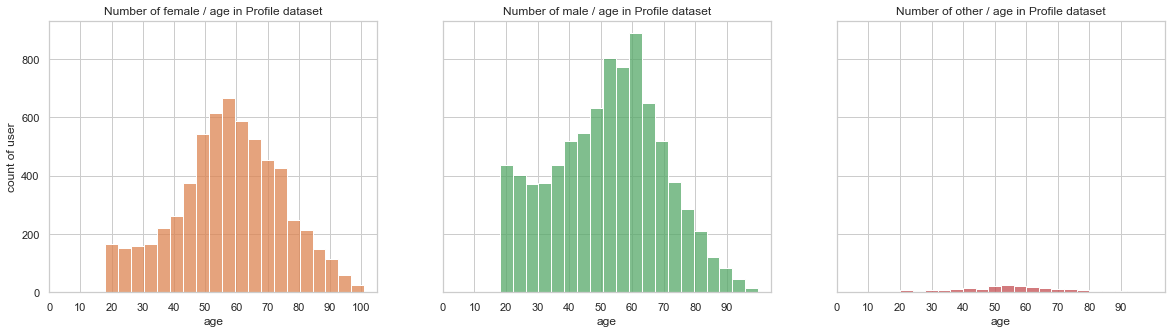

In [17]:
sns.set(style = 'whitegrid', font_scale = 1)
palette = sns.color_palette()

def getDf(gender):
    return cleaned_profile[cleaned_profile[f'gender_{gender}'] == 1]

count = 0
def smallHisplot(ax, col, gender):
    plt.sca(ax)
    df = getDf(gender)
    colMax = df[col].max()
    global count
    count += 1
    s = sns.histplot(df[col], bins = 20, color = palette[count]);
    s.set_xticks(range(0, int(colMax), int(colMax/10)))
    plt.title(f'Number of {gender} / {col} in Profile dataset')
    plt.ylabel('count of user')

def colGroup(col, ): 
    count = 0
    fig, ax = plt.subplots(figsize=(20,5), nrows = 1, ncols = 3, sharey=True)
    smallHisplot(ax[0], col, 'female')
    smallHisplot(ax[1], col, 'male')
    smallHisplot(ax[2], col, 'other')
    plt.show()
    fig.savefig(f'profile_{col}.svg', dpi = 300)

colGroup('age')

In [18]:
df = getDf('female')
group1 = df[df['age'].between(0, 17)]['age'].shape[0]
group2 = df[df['age'].between(18, 39)]['age'].shape[0]
group3 = df[df['age'].between(40, 75)]['age'].shape[0]
group4 = df[df['age'].between(76, 100)]['age'].shape[0]
print(df.shape[0], group1, group2,group3, group4)

6129 0 933 4323 868


In [19]:
df = getDf('male')
group1 = df[df['age'].between(0, 17)]['age'].shape[0]
group2 = df[df['age'].between(18, 39)]['age'].shape[0]
group3 = df[df['age'].between(40, 75)]['age'].shape[0]
group4 = df[df['age'].between(76, 100)]['age'].shape[0]
print(df.shape[0], group1, group2,group3, group4)

8484 0 2128 5600 756


In [20]:
getDf('other').shape[0]

212

#### summary 
From the 3 pictures above, in all age groups, people around 55-75 age show more in the dataset.  
After 65 years old, the count is decreasing. This dataset has no data before 18 years old, only includes adult.
The totle count of male is bigger than female and others.


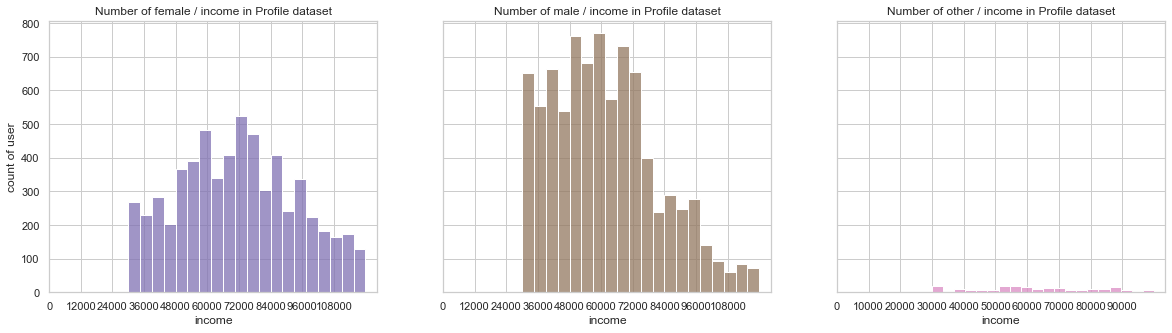

In [21]:
colGroup('income'); 

#### summary 
From the 3 pictures above, after 72000, the distribution of male and female is decreasing. 
The male decrease much more than female. 
The dataset does not include people under 30000.

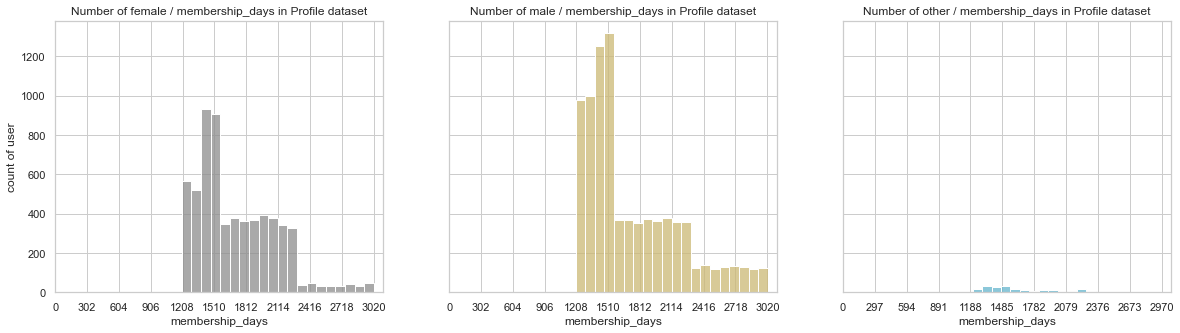

In [22]:
colGroup('membership_days')

#### summary
From the 3 pictures above, all groups shows the distribution is focusing on around 1160 to 1480 days which is about 4 years.  The dataset does not include members registered under 1160 days.

## 2.3 Transcript
### 2.2.1 overview of transcript data

the same as portfolio and profile,  check overview of transcript first

In [23]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
transcript.loc[transcript['event'] == 'offer completed'].head(5)

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,"{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}",0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,"{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}",0
12679,629fc02d56414d91bca360decdfa9288,offer completed,"{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}",0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,"{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}",0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,"{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}",0


In [24]:
transcript.describe().T

,count,mean,std,min,25%,50%,75%,max
time,306534.0,366.38294,200.326314,0.0,186.0,408.0,528.0,714.0


The event and value column need to be dummyed by type and value key, check what kinds of event in the dataset.

In [25]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [26]:
tran_values = transcript['value'].values
set([','.join(t.keys()) for t in tran_values])

{'amount', 'offer id', 'offer_id,reward'}

The possible keys in `value` column can be 'amount', 'offer id', or 'offer_id(with underscore), reward'
to clear about that, it need to split into amount , offer_id(offer id) , reward.

In total,  here need 3 columns need to be added.

### 2.2.2 clean transcript data

### Here are the process to clean *transcript.json*

1. clone original data 
2. extract value for each key from value column
3. create event dummies
4. drop value column 
5. rename person to customer_id
6. reorder columns
7. concat dummies to cloned data
8. reset index

In [27]:
def clean_transcript(transcript_df = transcript):
    '''
    Args:
        transcript_df: DataFrame of portfolio

    Returns:
        df: Cleaned DataFrame of portfolio
    '''

    #make copy of data
    df = transcript_df.copy()
    values =  df['value'].values
    flat_value_df = pd.DataFrame(
        [
            [t.get('offer id', t.get('offer_id')), 
             t.get('amount'), 
             t.get('reward')
            ] for t in values
        ], 
        columns =['offer_id', 'transcript_amount', 'transcript_reward']
    )
    
    #create channels_dummies and offer_dummies
    event_dummies = pd.get_dummies(df['event'], prefix = 'event')
    value_col = df['value'].str.join('').str.get_dummies().add_prefix('value_')

    #drop original columns
    df = df.drop(['value'], axis = 1)

    df = df.rename(columns = {'person': 'customer_id'})
    columns_order = ['customer_id', 'time', 'event']
    df = df.reindex(columns = columns_order)

    df = pd.concat([df, flat_value_df, event_dummies], axis = 1)
    df = df.rename(columns = {
        "event_offer completed": "event_offer_completed", 
        "event_offer viewed": "event_offer_viewed", 
        "event_offer received": "event_offer_received",
        "event_transaction": "event_transaction"
    })


    df = df.reset_index(drop=True)
    return df

In [28]:
cleaned_transcript = clean_transcript(transcript)

In [29]:
cleaned_transcript[cleaned_transcript['event'] == 'transaction'].head()

,customer_id,time,event,offer_id,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
12654,02c083884c7d45b39cc68e1314fec56c,0,transaction,None,0.83,NaN,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,transaction,None,34.56,NaN,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,0,transaction,None,13.23,NaN,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,transaction,None,19.51,NaN,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,0,transaction,None,18.97,NaN,0,0,0,1


In [30]:
cleaned_transcript.describe()

,time,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
count,306534.000000,138953.000000,33579.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,366.382940,12.777356,4.904137,0.109544,0.248837,0.188315,0.453304
std,200.326314,30.250529,2.886647,0.312321,0.432340,0.390964,0.497815
min,0.000000,0.050000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,2.780000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,8.890000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,528.000000,18.070000,5.000000,0.000000,0.000000,0.000000,1.000000
max,714.000000,1062.280000,10.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
customer_count = cleaned_transcript.groupby(['customer_id']).size().reset_index(name='event_counts').sort_values('event_counts', ascending=False)
customer_count


,customer_id,event_counts
9942,94de646f7b6041228ca7dec82adb97d2,51
9465,8dbfa485249f409aa223a2130f40634a,49
6268,5e60c6aa3b834e44b822ea43a3efea26,48
13901,d0a80415b84c4df4908b8403b19765e3,48
8077,79d9d4f86aca4bed9290350fb43817c2,48
...,...,...
3163,3045af4e98794a04a5542d3eac939b1f,2
1801,1bfe13d2453c4185a6486c6817e0d568,2
3859,3a4e53046c544134bb1e7782248631d1,2
13513,cae5e211053f4121a389a7da4d631f7f,2


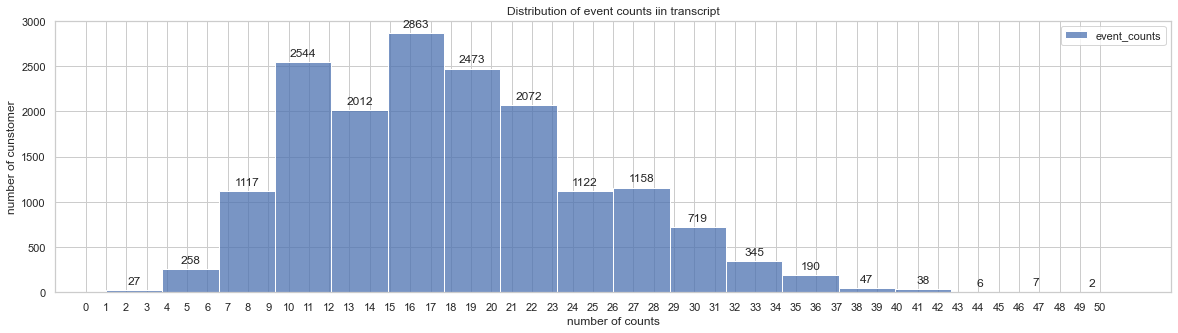

In [32]:
def drawCountDist(): 
    count = 0
    fig, ax = plt.subplots(figsize=(20,5), nrows = 1, ncols = 1)
    plt.sca(ax)
    df = customer_count
    colMax = df['event_counts'].max()
    count += 1
    g = sns.histplot(df, bins = 18);
    for p in g.patches:
        g.annotate(    
            p.get_height(), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center',
           va = 'center', 
           xytext = (0, 9), 
           textcoords = 'offset points'
        )
    g.set_xticks(range(0, int(colMax), int(colMax/50)))

    plt.title("Distribution of event counts iin transcript")
    plt.ylabel('number of cunstomer')
    plt.xlabel('number of counts')
    plt.show()
    fig.savefig(f'event_count_distribution.svg', dpi = 300)
drawCountDist()

summary:  The most customer get around 10-23 events. 
also some user get 7-9 and 24-29,  the center of this distruibution is about 2663.

#### 2.4.3  distribution of transaction data

In [33]:
cleaned_transcript.describe()

,time,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
count,306534.000000,138953.000000,33579.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,366.382940,12.777356,4.904137,0.109544,0.248837,0.188315,0.453304
std,200.326314,30.250529,2.886647,0.312321,0.432340,0.390964,0.497815
min,0.000000,0.050000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,2.780000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,8.890000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,528.000000,18.070000,5.000000,0.000000,0.000000,0.000000,1.000000
max,714.000000,1062.280000,10.000000,1.000000,1.000000,1.000000,1.000000


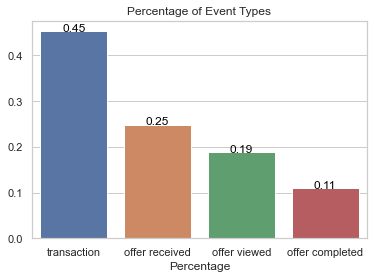

<Figure size 432x288 with 0 Axes>

In [34]:
percent = cleaned_transcript['event'].value_counts()/cleaned_transcript.shape[0]
g = sns.barplot(x = percent.index, y = percent.values)

for index, row in enumerate(percent):
    g.text(index,  row, round(row,2), color='black', ha="center")
    
plt.title('Percentage of Event Types')
plt.xlabel('Percentage')
plt.show()

plt.savefig('event_types.svg', dpi = 300)

#### summary
The most event is a single transaction. the number of offer completed is about half of offer received. 

### conclusion


Both profile dataset and transcript dataset have customer_id column. I can combine them to one dataset to give a profile more features. After feature selection and engineering,  machine learning model can have a rich and clean data to analysis. 

# 3. Feature Selection and Engineering
## 3.1 plan for feature selection
The Columns in profile and transcript dataset will be reviewed to put into a new dataset for later learning. And non-exist features willl be created.

In profile , gender , income , and age,  are normally need to keep to describe a user. since I have membership_days, the became_member_on  can be ignored.
In transcript, one customer may have multiple transcrips.  several events can happen for one users. count the offer_completed ,  offer_received,	offer_viewed, and	transaction are useful

It is also interesting to see how many times one cutomer interact with one offer. since in the portfolio dataset, it only has 10 offers, I create 10 columns to store the count of a offer happened in for a customer.


In [35]:
cleaned_transcript.head(200)

,customer_id,time,event,offer_id,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,offer received,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0,offer received,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0,1,0,0
6,c4863c7985cf408faee930f111475da3,0,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,offer received,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
9,31dda685af34476cad5bc968bdb01c53,0,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0


In [36]:
cleaned_transcript.describe()

,time,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
count,306534.000000,138953.000000,33579.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,366.382940,12.777356,4.904137,0.109544,0.248837,0.188315,0.453304
std,200.326314,30.250529,2.886647,0.312321,0.432340,0.390964,0.497815
min,0.000000,0.050000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,2.780000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,8.890000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,528.000000,18.070000,5.000000,0.000000,0.000000,0.000000,1.000000
max,714.000000,1062.280000,10.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
def lengthOfElementInArray(el):
    return lambda arr: len(
        list(
            filter(lambda x: x==el, arr)
        )
    )

def getChannelStr(df, df_port):
    return ['none_offer' if o == None else df_port[df_port['offer_id'] == o]['channels_str'] for o in df]

# Read in successful offer, view, and receive:
def clean_data(df_portfolio, df_profile, df_transcript):
    '''
    Combine df_portfolio, df_profile, df_offer, and
    df_transaction

    Args:
        df_portfolio (pandas.DataFrame): Clean DataFrame of portfolio
        df_profile (pandas.DataFrame): Clean DataFrame of profile
        df_offer (pandas.DataFrame): Clean DataFrame of offer
        df_transaction (pandas.DataFrame): Clean DataFrame of transaction
    Returns:
        clean_result (pandas.DataFrame): DataFrame containing information from
                                       all of the data input in the desired 
                                       format
    '''
#     clean_result = []
#     customer_list = df_profile['customer_id'].unique().tolist()
#     df_transcript
    merged_df = pd.merge(df_profile, df_transcript, how='left', on='customer_id', suffixes=('_profile', 'transcript'))
    merged_df = pd.merge(merged_df, df_portfolio, how='left', on='offer_id', suffixes=('_merge', '_portfolio'))
    merged_df['channels_str'] = merged_df['channels'].str.join('_')
    merged_df.reset_index(drop=True)
    merged_df.reindex()
    
    
    group_fn = merged_df.groupby("customer_id")
    agg_df =group_fn.agg(
        age=pd.NamedAgg("age", "first"),
        income=("income", "first"),
        became_member_on=("became_member_on", "first"),
        membership_days=("membership_days", "first"),
        gender_female=("gender_female", "first"),
        gender_male=("gender_male", "first"),
        gender_other=("gender_other", "first"),
        gender=("gender", "first"),
        time=("time", "mean"),
        amount=("transcript_amount", "sum"),
        reward=("transcript_reward", "sum"),
        offer_index=("offer_index", list),
        offer_count=('offer_id', "count"),
        event_completed=("event_offer_completed", "sum"),
        event_received=("event_offer_received", "sum"),
        event_viewed=("event_offer_viewed", "sum"),
        event_transaction=("event_transaction", "sum"),
        difficulty=("difficulty", 'mean'),
        duration=("duration", 'mean'),
        channel_email=("channel_email", 'sum'),
        channel_mobile=("channel_mobile", 'sum'),
        channel_social=("channel_social", 'sum'),
        channel_web=("channel_web", 'sum'),
        offer_bogo=("offer_bogo", 'sum'),
        offer_discount=("offer_discount", 'sum'),
        offer_informational=("offer_informational", 'sum'),
    ).reset_index()

    agg_df["became_member_on"] = agg_df['became_member_on'].apply(lambda x: str(x)[0:4])
    agg_df = agg_df.drop(['offer_index'], axis=1)
    agg_df.reset_index()
    return [agg_df, merged_df]

In [38]:
[grouped_df, merged_df] = clean_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)
grouped_df.head()

,customer_id,age,income,became_member_on,membership_days,gender_female,gender_male,gender_other,gender,time,amount,reward,offer_count,event_completed,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,0009655768c64bdeb2e877511632db8f,33,72000.0,2017,1662,0,1,0,M,470.700000,127.60,9.0,12,3,5,4,8,5.416667,6.083333,12.0,12.0,8.0,10.0,3.0,5.0,4.0
1,0011e0d4e6b944f998e987f904e8c1e5,40,57000.0,2018,1399,0,0,1,O,365.000000,79.46,13.0,13,3,5,5,5,7.384615,6.615385,13.0,10.0,5.0,11.0,3.0,6.0,4.0
2,0020c2b971eb4e9188eac86d93036a77,59,90000.0,2016,2075,1,0,0,F,335.684211,196.86,14.0,11,3,5,3,8,8.181818,7.090909,11.0,11.0,11.0,8.0,4.0,5.0,2.0
3,0020ccbbb6d84e358d3414a3ff76cffd,24,60000.0,2016,1823,1,0,0,F,374.869565,154.05,13.0,11,3,4,4,12,4.636364,5.727273,11.0,11.0,8.0,9.0,6.0,3.0,2.0
4,003d66b6608740288d6cc97a6903f4f0,26,73000.0,2017,1601,1,0,0,F,390.600000,48.34,9.0,12,3,5,4,18,8.333333,7.833333,12.0,10.0,8.0,10.0,0.0,8.0,4.0


In [39]:
merged_df.head()

,customer_id,age,gender,income,became_member_on,membership_days,gender_female,gender_male,gender_other,time,event,offer_id,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_index,reward,difficulty,duration,channels,offer_type,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,channels_str
0,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,1577,1,0,0,18,transaction,None,21.51,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,1577,1,0,0,144,transaction,None,32.28,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,1577,1,0,0,408,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,3.0,5.0,5.0,7.0,"[web, email, mobile]",bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,web_email_mobile
3,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,1577,1,0,0,504,offer received,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,1,0,0,2.0,0.0,0.0,4.0,"[web, email, mobile]",informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,web_email_mobile
4,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,1577,1,0,0,528,transaction,None,23.22,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
grouped_df.describe()

,age,income,membership_days,gender_female,gender_male,gender_other,time,amount,reward,offer_count,event_completed,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14820.000000,14820.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1723.478988,0.413423,0.572277,0.014300,367.089461,117.028155,10.829073,10.037437,2.188465,4.485734,3.363238,8.361349,7.825454,6.588096,10.037437,9.205936,6.607757,8.097673,4.305835,4.203103,1.528499
std,17.383705,21598.299410,419.205158,0.492464,0.494765,0.118729,59.566006,129.965016,9.280086,3.115277,1.582193,1.074694,1.291316,5.182667,2.466506,1.077336,3.115277,3.173460,3.202722,3.287499,2.883431,2.895363,1.558237
min,18.000000,30000.000000,1201.000000,0.000000,0.000000,0.000000,113.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,1409.000000,0.000000,0.000000,0.000000,328.235294,31.450000,3.000000,8.000000,1.000000,4.000000,2.000000,4.000000,6.250000,5.857143,8.000000,7.000000,4.000000,6.000000,2.000000,2.000000,0.000000
50%,55.000000,64000.000000,1559.000000,0.000000,1.000000,0.000000,367.071429,87.040000,10.000000,10.000000,2.000000,5.000000,3.000000,7.000000,7.727273,6.571429,10.000000,9.000000,6.000000,8.000000,4.000000,4.000000,2.000000
75%,66.000000,80000.000000,1998.000000,1.000000,1.000000,0.000000,405.529412,160.900000,17.000000,12.000000,3.000000,5.000000,4.000000,11.000000,9.285714,7.285714,12.000000,11.000000,9.000000,10.000000,6.000000,6.000000,2.000000
max,101.000000,120000.000000,3024.000000,1.000000,1.000000,1.000000,588.000000,1608.690000,55.000000,18.000000,6.000000,6.000000,6.000000,36.000000,20.000000,10.000000,18.000000,18.000000,18.000000,18.000000,18.000000,17.000000,10.000000


In [41]:
merged_df.describe()

,age,income,membership_days,gender_female,gender_male,gender_other,time,transcript_amount,transcript_reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_index,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000,32444.000000,272762.000000,272762.000000,272762.000000,272762.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000
mean,53.840696,64337.000755,1782.291950,0.414651,0.570791,0.014558,366.707694,13.996325,4.948249,0.118946,0.243806,0.182797,0.454451,4.545936,4.442445,7.890561,6.625207,1.0,0.917160,0.658311,0.806747,0.428978,0.418743,0.152280
std,17.551337,21243.762941,428.810204,0.492663,0.494964,0.119777,200.359087,31.749420,2.905376,0.323726,0.429378,0.386500,0.497922,2.888141,3.372362,5.041335,2.133035,0.0,0.275641,0.474277,0.394851,0.494932,0.493355,0.359293
min,18.000000,30000.000000,1201.000000,0.000000,0.000000,0.000000,0.000000,0.050000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,48000.000000,1443.000000,0.000000,0.000000,0.000000,186.000000,3.660000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,55.000000,62000.000000,1672.000000,0.000000,1.000000,0.000000,408.000000,10.800000,5.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,66.000000,78000.000000,2063.000000,1.000000,1.000000,0.000000,528.000000,19.130000,5.000000,0.000000,0.000000,0.000000,1.000000,7.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,3024.000000,1.000000,1.000000,1.000000,714.000000,1062.280000,10.000000,1.000000,1.000000,1.000000,1.000000,9.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


After above clean and engineering work, I have more useful data for Machine leaning to process. for now store the data for faster and reuseable purpose 

In [42]:
grouped_df.to_csv('data/grouped_df.csv')
merged_df.to_csv('data/merged_df.csv')

grouped_df is aggreated dataset by custormers. merged_df represent data by each event

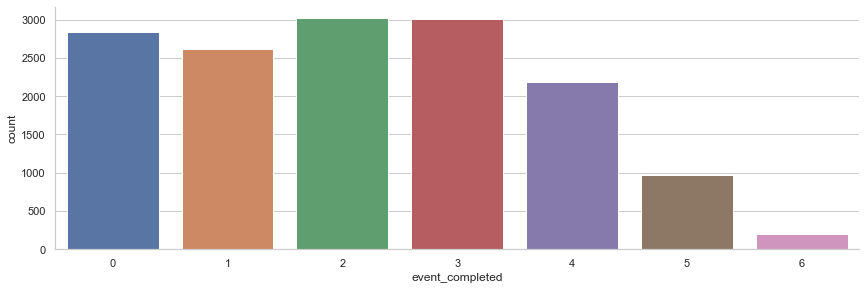

In [43]:
snsplot = sns.catplot(data = grouped_df, x = 'event_completed', 
                       kind = 'count', height=4, aspect=3);
plt.savefig('grouped_df.svg');

## 3.2 visulized the merged data and aggreated data after engineering

A quick plot above shows distribution of offer completed count by customer. I can see that similar number of customer comleted 0, 1,2,3,4 offers, and a bit less people finished 5 times offer. a litte amount people finished  6 offer.

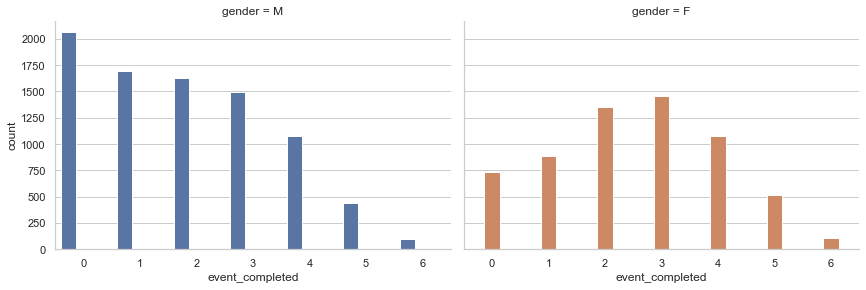

In [44]:
snsplot = sns.catplot(data = grouped_df[grouped_df['gender'] != 'O'], x = 'event_completed', 
                      hue="gender", hue_order=['M','F','O'],
                      kind = 'count', col = 'gender',  height=4, aspect=1.5);
plt.savefig('grouped_df_offer_completed_count_dist.svg');


Another quick plot shows the different of distribution offer complete between male and female
The males do not finish offers through the incresing of offer count, while more of the female finsished 2 or 3 offers.

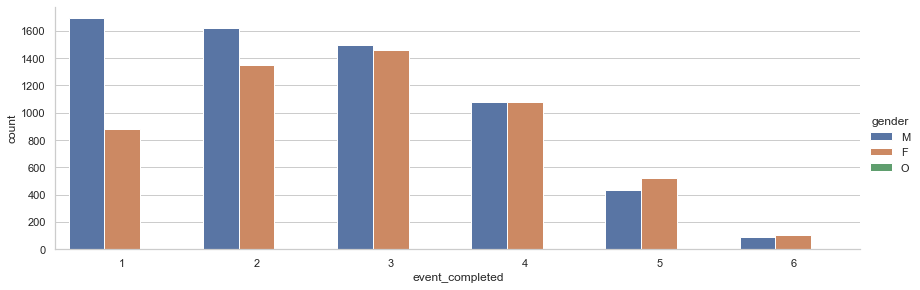

In [45]:
df = grouped_df
focus_df = df.loc[df['event_completed'] != 0 ].loc[df['gender'] != 'O']
snsplot = sns.catplot(data = focus_df, x = 'event_completed', hue="gender", hue_order=['M','F','O'],
                       kind = 'count', height=4, aspect=3);
plt.savefig('offer_completed_count_dist.svg');

After remove gender 'other' and remove not completed offers, I can get plot like above.

It shows offer completed count distribution and detail segmentation of gender group in each offer count group. Much less female complete offer when offer finish count is 0 and 1. Similar the males and the females finished when count is 2 ,3, 4,  5, and 6. 

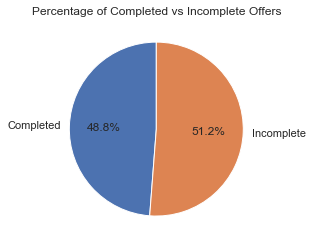

In [46]:
complete = grouped_df['event_completed'].sum()
recieved = grouped_df['event_received'].sum()
incomplete = recieved - complete
labels = ['Completed', 'Incomplete']
sizes = [complete, incomplete]
pie_plot = plt.pie(sizes, labels = labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Completed vs Incomplete Offers')
plt.show()

This pie chart shows that how balanced the data set is. this step verified the dataset is fit the puporse of the usaged in machine learning.

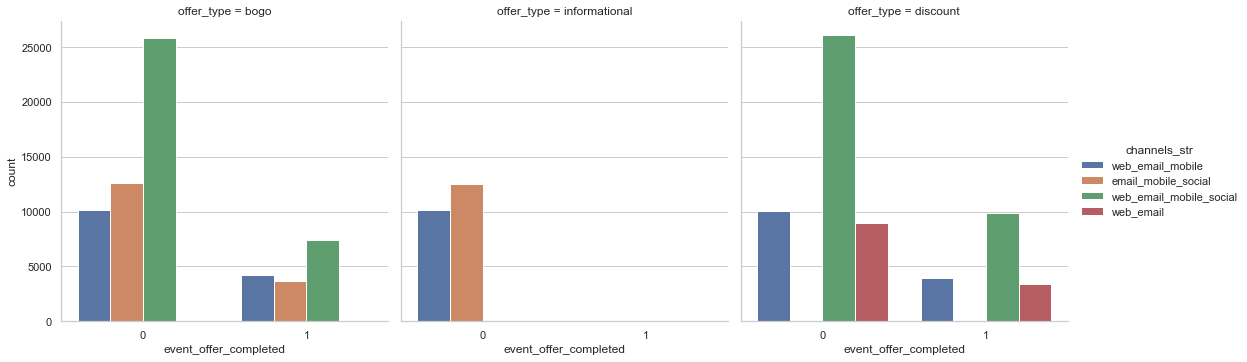

In [47]:
sns_plot = sns.catplot(data = merged_df, x = 'event_offer_completed', hue = 'channels_str',
                        kind = 'count', col = 'offer_type' );

plt.savefig('merged_df_channel_dist.svg', dpi = 300);

The above plots shows the distribution of channels in offer_completed or offer_incompleted with different offer type. Althrough, there are 4 channels means 24 combinations can happen, but in dataset only 4 combinations of appears. the less happened is web_email combination.

Overall, the web_email channel happend less than other channels, and no informational offer get completed.
and seems more web_email_mobile channels get completed.

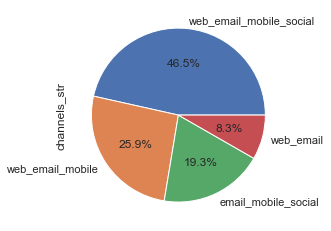

In [48]:
%matplotlib inline
sns.set()
df = merged_df["channels_str"].value_counts()
df.plot.pie(y='' ,autopct="%.1f%%");

In [49]:
grouped_df.shape

(14825, 26)

## 3.3. Conclusion
The grouped DataFrame ends up having 26 columns. All numberic column will be used for the machine learning model. In next step, Machine leaning predictioin, the target column is 'event_offer_completed'. I will verify the dataset and choose the most related colomuns for machine learning.

# 4. Data preprocessing for Machine Learning


To choose the best machine learning model , this section will do another turn Data preprocessing, normalizing, and engeneering.

In [50]:
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split


## 4.1. Data Preprocessing for Machine Learning

Continuing to prepare the data from the previous section:
- Load data
- Define target split point as a rule to categorize customer into positive and negative
- Convert continuous data to binary data by cut into binary columns
- Remove categorical and unique columns including
    'customer_id', 'event_completed', 'complete_rate','gender', 'gender_other'
  keep 'complete_target'
- Normalize the all numberical features:
- Create a heatmap to analyze the signifcant correlations
- Remove less relavent/importance features and Shuffle the data

### 4.1.1 Load data

In [51]:
data = pd.read_csv('data/grouped_df.csv')
data.head()
data.describe()

,Unnamed: 0,age,income,became_member_on,membership_days,gender_female,gender_male,gender_other,time,amount,reward,offer_count,event_completed,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14820.000000,14820.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,7412.000000,54.393524,65404.991568,2016.620169,1723.478988,0.413423,0.572277,0.014300,367.089461,117.028155,10.829073,10.037437,2.188465,4.485734,3.363238,8.361349,7.825454,6.588096,10.037437,9.205936,6.607757,8.097673,4.305835,4.203103,1.528499
std,4279.753206,17.383705,21598.299410,1.198245,419.205158,0.492464,0.494765,0.118729,59.566006,129.965016,9.280086,3.115277,1.582193,1.074694,1.291316,5.182667,2.466506,1.077336,3.115277,3.173460,3.202722,3.287499,2.883431,2.895363,1.558237
min,0.000000,18.000000,30000.000000,2013.000000,1201.000000,0.000000,0.000000,0.000000,113.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3706.000000,42.000000,49000.000000,2016.000000,1409.000000,0.000000,0.000000,0.000000,328.235294,31.450000,3.000000,8.000000,1.000000,4.000000,2.000000,4.000000,6.250000,5.857143,8.000000,7.000000,4.000000,6.000000,2.000000,2.000000,0.000000
50%,7412.000000,55.000000,64000.000000,2017.000000,1559.000000,0.000000,1.000000,0.000000,367.071429,87.040000,10.000000,10.000000,2.000000,5.000000,3.000000,7.000000,7.727273,6.571429,10.000000,9.000000,6.000000,8.000000,4.000000,4.000000,2.000000
75%,11118.000000,66.000000,80000.000000,2017.000000,1998.000000,1.000000,1.000000,0.000000,405.529412,160.900000,17.000000,12.000000,3.000000,5.000000,4.000000,11.000000,9.285714,7.285714,12.000000,11.000000,9.000000,10.000000,6.000000,6.000000,2.000000
max,14824.000000,101.000000,120000.000000,2018.000000,3024.000000,1.000000,1.000000,1.000000,588.000000,1608.690000,55.000000,18.000000,6.000000,6.000000,6.000000,36.000000,20.000000,10.000000,18.000000,18.000000,18.000000,18.000000,18.000000,17.000000,10.000000


### 4.1.2 split data into positive and negative

Target of this dataset is to find out which profile may complete a offer.  because an customer may complete and incomplete in multiple offsers,  I need to set a line to distinct customers who may complete offer. One way to do that is to check the complete rate for each customer.

In [52]:
data['complete_rate'] = data['event_completed'] / (data['event_received']+0.00001)
data[['complete_rate']].mean()

complete_rate    0.487376
dtype: float64

The average of of the complete_rate column is 0.487376, I may use it to generate a column 'complete_target' to split customers into 2 groups.

In [53]:
data[['age', 'became_member_on', 'membership_days']].describe().T

,count,mean,std,min,25%,50%,75%,max
age,14825.0,54.393524,17.383705,18.0,42.0,55.0,66.0,101.0
became_member_on,14825.0,2016.620169,1.198245,2013.0,2016.0,2017.0,2017.0,2018.0
membership_days,14825.0,1723.478988,419.205158,1201.0,1409.0,1559.0,1998.0,3024.0


The describe method shows the data range of each column, age is between 18-101, became_member_on is between 2013-2018, and membership_days is from 1193-3016

### 4.1.3 convert continuous data to binary data

In [54]:
data['complete_target'] = (data['complete_rate'] >= 0.487542).astype(int)
myear_dummies = pd.get_dummies(data['became_member_on'].astype(str))

age_cut_points = [17, 40, 60, 80, 101]
data['age_segment'] = pd.cut(data['age'], age_cut_points).astype(str)
age_dummies = pd.get_dummies(data['age_segment'])

member_days_cut_points = [1192, 1500, 2000, 2500, 3016]
data['mdays_segment'] = pd.cut(data['membership_days'], member_days_cut_points).astype(str)
mdays_dummies = pd.get_dummies(data['mdays_segment'])

concat_data = pd.concat([data, age_dummies, myear_dummies, mdays_dummies], axis = 1)
# concat_data.columns = concat_data.columns.map(str)

#remove original and categorical columns
concat_data.drop(labels=['age', 'became_member_on', 'mdays_segment', 'age_segment', 'Unnamed: 0'], inplace=True, axis=1 )
concat_data.rename(columns={
    '2013': 'myear_2013',
    '2014': 'myear_2014',
    '2015': 'myear_2015',
    '2016': 'myear_2016',
    '2017': 'myear_2017',
    '2018': 'myear_2018',   
    '(17, 40]': 'age_17_40',
    '(40, 60]': 'age_40_60',
    '(60, 80]': 'age_60_80',
    '(80, 101]': 'age_80_101',
    '(1192, 1500]': 'mdays_1192_1500',
    '(1500, 2000]': 'mdays_1500_2000',
    '(2000, 2500]': 'mdays_2000_2500',
    '(2500, 3016]': 'mdays_2500_3016',
},  inplace=True)

concat_data

,customer_id,income,membership_days,gender_female,gender_male,gender_other,gender,time,amount,reward,offer_count,event_completed,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,complete_rate,complete_target,age_17_40,age_40_60,age_60_80,age_80_101,myear_2013,myear_2014,myear_2015,myear_2016,myear_2017,myear_2018,mdays_1192_1500,mdays_1500_2000,mdays_2000_2500,mdays_2500_3016
0,0009655768c64bdeb2e877511632db8f,72000.0,1662,0,1,0,M,470.700000,127.60,9.0,12,3,5,4,8,5.416667,6.083333,12.0,12.0,8.0,10.0,3.0,5.0,4.0,0.599999,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1399,0,0,1,O,365.000000,79.46,13.0,13,3,5,5,5,7.384615,6.615385,13.0,10.0,5.0,11.0,3.0,6.0,4.0,0.599999,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0020c2b971eb4e9188eac86d93036a77,90000.0,2075,1,0,0,F,335.684211,196.86,14.0,11,3,5,3,8,8.181818,7.090909,11.0,11.0,11.0,8.0,4.0,5.0,2.0,0.599999,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,1823,1,0,0,F,374.869565,154.05,13.0,11,3,4,4,12,4.636364,5.727273,11.0,11.0,8.0,9.0,6.0,3.0,2.0,0.749998,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,73000.0,1601,1,0,0,F,390.600000,48.34,9.0,12,3,5,4,18,8.333333,7.833333,12.0,10.0,8.0,10.0,0.0,8.0,4.0,0.599999,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,fff3ba4757bd42088c044ca26d73817a,83000.0,2241,1,0,0,F,267.652174,580.98,9.0,12,3,6,3,11,6.250000,6.750000,12.0,12.0,6.0,9.0,3.0,6.0,3.0,0.499999,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
14821,fff7576017104bcc8677a8d63322b5e1,73000.0,1469,0,1,0,M,362.666667,29.94,9.0,12,3,5,4,6,9.166667,8.166667,12.0,12.0,10.0,10.0,6.0,6.0,0.0,0.599999,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0
14822,fff8957ea8b240a6b5e634b6ee8eafcf,56000.0,1359,0,1,0,M,447.600000,12.15,0.0,5,0,3,2,5,8.000000,6.800000,5.0,5.0,4.0,5.0,2.0,2.0,1.0,0.000000,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
14823,fffad4f4828548d1b5583907f2e9906b,34000.0,1750,0,1,0,M,327.130435,88.83,15.0,11,3,4,4,12,4.090909,5.181818,11.0,11.0,8.0,9.0,9.0,0.0,2.0,0.749998,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0


#### remove isnull rows

Give a check data validity by looking for NaN data, use `isnull`

In [55]:
null_df = concat_data.isnull().sum()
null_df[null_df != 0]

difficulty    5
duration      5
dtype: int64

I can see `difficulty`  and `duration` column have NaN in dataSet,  give a detail look into them

In [56]:
isnull_data = concat_data.loc[concat_data['difficulty'].isnull() | concat_data['duration'].isnull()]
isnull_data

,customer_id,income,membership_days,gender_female,gender_male,gender_other,gender,time,amount,reward,offer_count,event_completed,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,complete_rate,complete_target,age_17_40,age_40_60,age_60_80,age_80_101,myear_2013,myear_2014,myear_2015,myear_2016,myear_2017,myear_2018,mdays_1192_1500,mdays_1500_2000,mdays_2000_2500,mdays_2500_3016
1073,12ede229379747bd8d74ccdc20097ca3,70000.0,2226,0,1,0,M,332.0,63.25,0.0,0,0,0,0,3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3354,3a4874d8f0ef42b9a1b72294902afea9,88000.0,1910,1,0,0,F,426.0,67.62,0.0,0,0,0,0,3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
10206,ae8111e7e8cd4b60a8d35c42c1110555,72000.0,1767,1,0,0,F,474.0,86.43,0.0,0,0,0,0,5,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
11533,c6e579c6821c41d1a7a6a9cf936e91bb,35000.0,1486,1,0,0,F,343.5,6.95,0.0,0,0,0,0,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
13646,eb540099db834cf59001f83a4561aef3,34000.0,1501,1,0,0,F,361.5,26.01,0.0,0,0,0,0,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


Looks like `difficulty.isnull` and `duration.isnull` are the same rows.  simple delete these 5 row from dataset

In [57]:
concat_data.drop(isnull_data.index, inplace=True)
concat_data.shape

(14820, 40)

### 4.1.4 normalize data

In [58]:
only_number_df = concat_data.copy()
only_number_df.drop(labels=['customer_id', 'event_completed', 'complete_rate','gender'], inplace=True, axis=1)

column_normalize = set(only_number_df.columns)
column_normalize

{'age_17_40',
 'age_40_60',
 'age_60_80',
 'age_80_101',
 'amount',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'complete_target',
 'difficulty',
 'duration',
 'event_received',
 'event_transaction',
 'event_viewed',
 'gender_female',
 'gender_male',
 'gender_other',
 'income',
 'mdays_1192_1500',
 'mdays_1500_2000',
 'mdays_2000_2500',
 'mdays_2500_3016',
 'membership_days',
 'myear_2013',
 'myear_2014',
 'myear_2015',
 'myear_2016',
 'myear_2017',
 'myear_2018',
 'offer_bogo',
 'offer_count',
 'offer_discount',
 'offer_informational',
 'reward',
 'time'}

In [59]:
normalized_data = only_number_df.copy()
for col in column_normalize:
    normalized_data[col] = minmax_scale(normalized_data[col])


In [60]:
normalized_data.head()

,income,membership_days,gender_female,gender_male,gender_other,time,amount,reward,offer_count,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,complete_target,age_17_40,age_40_60,age_60_80,age_80_101,myear_2013,myear_2014,myear_2015,myear_2016,myear_2017,myear_2018,mdays_1192_1500,mdays_1500_2000,mdays_2000_2500,mdays_2500_3016
0,0.466667,0.252880,0.0,1.0,0.0,0.752755,0.079319,0.163636,0.647059,0.8,0.666667,0.222222,0.270833,0.440476,0.647059,0.666667,0.444444,0.555556,0.166667,0.294118,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.300000,0.108612,0.0,0.0,1.0,0.529961,0.049394,0.236364,0.705882,0.8,0.833333,0.138889,0.369231,0.516484,0.705882,0.555556,0.277778,0.611111,0.166667,0.352941,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.666667,0.479430,1.0,0.0,0.0,0.468169,0.122373,0.254545,0.588235,0.8,0.500000,0.222222,0.409091,0.584416,0.588235,0.611111,0.611111,0.444444,0.222222,0.294118,0.2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.333333,0.341196,1.0,0.0,0.0,0.550764,0.095761,0.236364,0.588235,0.6,0.666667,0.333333,0.231818,0.389610,0.588235,0.611111,0.444444,0.500000,0.333333,0.176471,0.2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.477778,0.219419,1.0,0.0,0.0,0.583921,0.030049,0.163636,0.647059,0.8,0.666667,0.500000,0.416667,0.690476,0.647059,0.555556,0.444444,0.555556,0.000000,0.470588,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 4.1.5 get headmap of noramlized data 

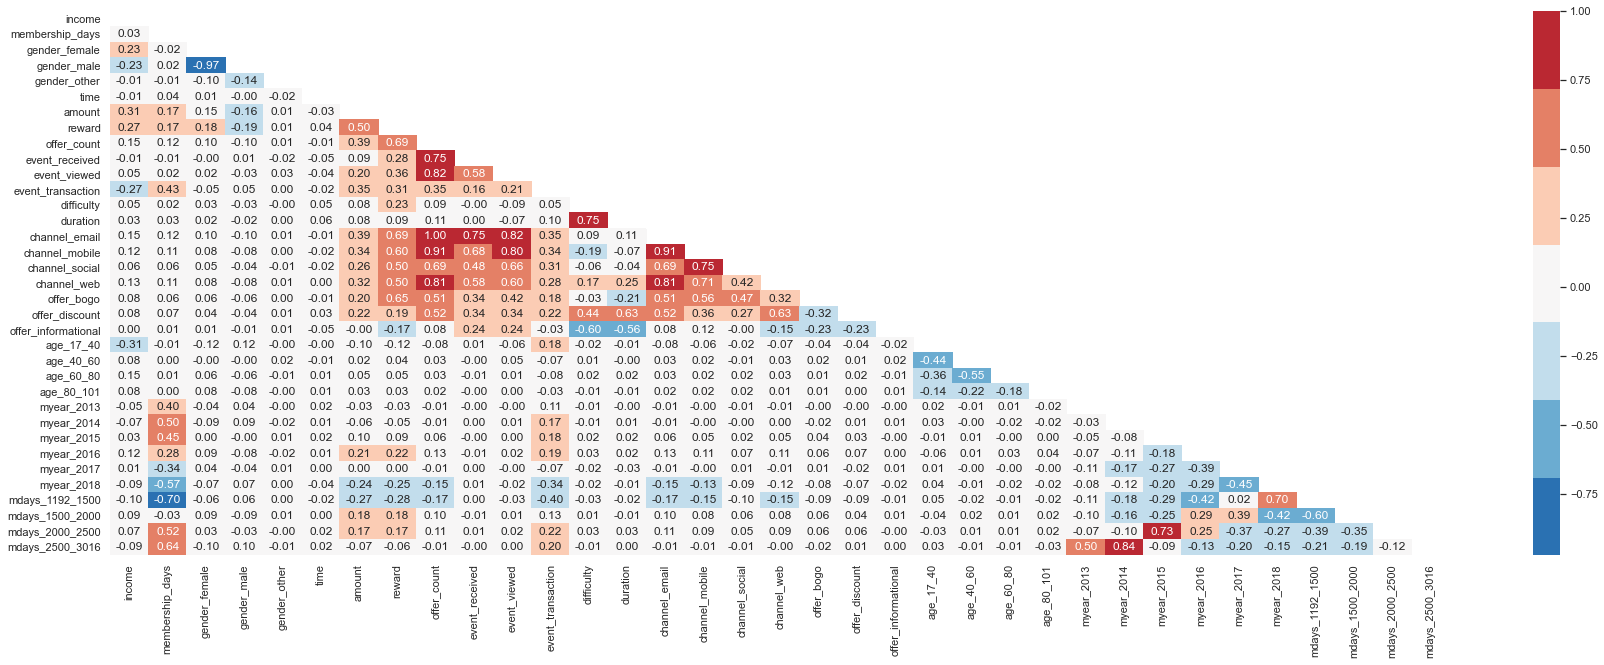

In [61]:
heatmap_vars = normalized_data.drop(labels=['complete_target'], axis=1)
mask = np.triu( heatmap_vars.corr())
with sns.axes_style('white'):
    [_, ax] = plt.subplots(figsize = (30, 10))
    ax = sns.heatmap(heatmap_vars.corr(), cmap = sns.color_palette("RdBu_r", 7), annot = True, fmt = '.2f', mask = mask)

figure = ax.get_figure()    
figure.savefig('heatmap_features.svg', dpi = 300)


In [62]:
heatmap_vars.columns

Index(['income', 'membership_days', 'gender_female', 'gender_male',
       'gender_other', 'time', 'amount', 'reward', 'offer_count',
       'event_received', 'event_viewed', 'event_transaction', 'difficulty',
       'duration', 'channel_email', 'channel_mobile', 'channel_social',
       'channel_web', 'offer_bogo', 'offer_discount', 'offer_informational',
       'age_17_40', 'age_40_60', 'age_60_80', 'age_80_101', 'myear_2013',
       'myear_2014', 'myear_2015', 'myear_2016', 'myear_2017', 'myear_2018',
       'mdays_1192_1500', 'mdays_1500_2000', 'mdays_2000_2500',
       'mdays_2500_3016'],
      dtype='object')

### 4.1.6 Remove less relavent features and Shuffle the data

From the heatmap showing above, the most features are relavent except `offer_informational`, `age_80_101`, `mdays_2000_2500`, `mdays_2500_3016`

In [63]:
shuffled_data = shuffle(normalized_data, random_state=42)

In [64]:
#select columns as train data set
train = shuffled_data[[
'income',
'membership_days',
'gender_female',
'gender_male',
'gender_other',
# 'time',
'amount',
'reward',
'offer_count',
'event_received',
'event_viewed',
'event_transaction',
'difficulty',
'duration',
'channel_email',
'channel_mobile',
'channel_social',
'channel_web',
'offer_bogo',
# 'offer_discount',
# 'offer_informational',
# 'age_segment',
# 'mdays_segment',
'age_17_40',
'age_40_60',
'age_60_80',
# 'age_80_101',
'myear_2013',
'myear_2014',
'myear_2015',
'myear_2016',
'myear_2017',
'myear_2018',
'mdays_1192_1500',
'mdays_1500_2000',
# 'mdays_2000_2500',
# 'mdays_2500_3016'
]]

target = np.ravel(shuffled_data['complete_target'])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=40)

# 5 Machine Learning Modeling and Analysis 

This section including following steps:
1. Model selection , test different models
2. Feature importance
3. Predict test data
4. Confusion Matrix

## 5.1 Model selection
As states at very beginning, the dataset is a realworld inbalanced dataset and lower false negative is more important than lower false positive.  therefor f1-score can fit better as the metric.
This section will get train and test data , and use GridSearchCV to evaluate f1-score for each algorithm,
find the best score and faster one to build Model

In [66]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [67]:
def get_clf_f1(estimator, X, y, param_grid={}, printout=True):

    """
    Using GridSearchCV to get f1_score of a classifier
    
    INPUT:
    - estimator: classifier to fit
    - param_grid: a dict store classifier parameters used with GridSearchCV
    - X_train_scaled: a df training features
    - y_train: numpy.ndarray, training label
            
    OUTPUT:
    - classifier attributes and time_used: input classifier fitted to the training data
    """

    if (printout) :
        print("-"*40)
        print(estimator.__class__.__name__)

    start = time.time()
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1', cv=5, verbose=1)
    grid.fit(X, y)
    end = time.time()
    time_used = round(end-start,2)

    if (printout) :
        print("Time Used: {} secs".format(time_used))
        print("F1 Score: {}".format(round(grid.best_score_,6)))
    
    return grid.best_score_, grid.best_estimator_, time_used

In [68]:
# Initialize classification algorithms
logistic_clf = LogisticRegression(random_state=42, max_iter=400) # LogisticRegression
forest_clf = RandomForestClassifier(random_state=42) # RandomForestClassifier
gradient_clf = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier
ada_boost_clf = AdaBoostClassifier(random_state=42) # AdaBoostClassifier

In [69]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_estimators = []
clf_time_used = []

for clsf in [logistic_clf, forest_clf, gradient_clf, ada_boost_clf]:
    score, estimator, time_used = get_clf_f1(clsf, X_train.values, y_train, {}, printout=True)
    clf_names.append(clsf.__class__.__name__)
    clf_scores.append(score)
    clf_estimators.append(estimator)
    clf_time_used.append(time_used)

----------------------------------------
LogisticRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Time Used: 0.55 secs
F1 Score: 0.971941
----------------------------------------
RandomForestClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Time Used: 4.71 secs
F1 Score: 0.9834
----------------------------------------
GradientBoostingClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Time Used: 9.37 secs
F1 Score: 0.981209
----------------------------------------
AdaBoostClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Time Used: 2.56 secs
F1 Score: 0.978552


The classifier `RandomForestClassifier` has 0.9834, when GridSearchCV given a cv=5. `RandomForestClassifier` gets better score but slower than `AdaBoostClassifier` and `LogisticRegression`. Meanwhile `RandomForestClassifier` is runing less than half time of `GradientBoostingClassifier`. Considering the balance between score and time, the best performing classifier algorithm among the above 4 classifiers is RandomForestClassifier.

#### conclusion  use RandomForestClassifier to build model

In [70]:
# Give a param grid in GridSearchCV to tune the clf
def get_forest_score(param_grid, x, y):
    """
    Using GridSearchCV to get f1_score of a classifier
    
    INPUT:
    - param_grid (dict) : params include  n_estimators, max_depth, min_samples_split, min_samples_leaf
    - x (np.array): x_train values
    - y (np.array): y_train
            
    OUTPUT:
    - classifier attributes and time_used: input classifier fitted to the training data
    """


    forest_clf = RandomForestClassifier(random_state=42)
    forest_score, forest_estimator, time_used = get_clf_f1(
        forest_clf, x, y, param_grid, printout=False
    )
    print('----------\nforest_score',forest_score, 
          '\nforest_estimator',forest_estimator, 
          '\ntime_used', time_used
         )
    return forest_score, forest_estimator, time_used



In [71]:
print('try different split in param grid')
forest_score, forest_estimator, time_used = get_forest_score(
    {'n_estimators': [100], 'max_depth': [16,32, 64], 'min_samples_split': [2, 8], 'min_samples_leaf': [1,2]},
    X_train.values,
    y_train,
)


try different split in param grid
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
forest_score 0.9834003588468757 
forest_estimator RandomForestClassifier(max_depth=32, random_state=42) 
time_used 43.35


#### conclution: When max_depth is 32,  `RandomForestClassifier` get the best score 0.9823198355137828 (Fitting 5 folds)

I can see that after fine tuning the trained RandomForestClassifier, we get the better f1_score of 0.981.

## 5.2 Feature importance by RandomForestClassifier

In [72]:
# create feature importance dataframe
importances_df = pd.DataFrame(
    forest_estimator.feature_importances_,
    index=X_train.columns.tolist(),
    columns=['importances']
)

# importances_df.rename(columns={'index': 'feature_name'}, inplace=True)
importances_df['rate'] =  (importances_df['importances'] / importances_df['importances'].sum()) * 100
importances_df = importances_df.sort_values(by=['rate'], ascending=False).reset_index()
importances_df

,index,importances,rate
0,reward,0.342918,34.291820
1,amount,0.152374,15.237423
2,event_received,0.078237,7.823747
3,offer_count,0.063438,6.343771
4,channel_email,0.051683,5.168296
5,duration,0.040321,4.032145
6,channel_web,0.036399,3.639881
7,event_viewed,0.032365,3.236474
8,membership_days,0.030073,3.007285
9,difficulty,0.029928,2.992783


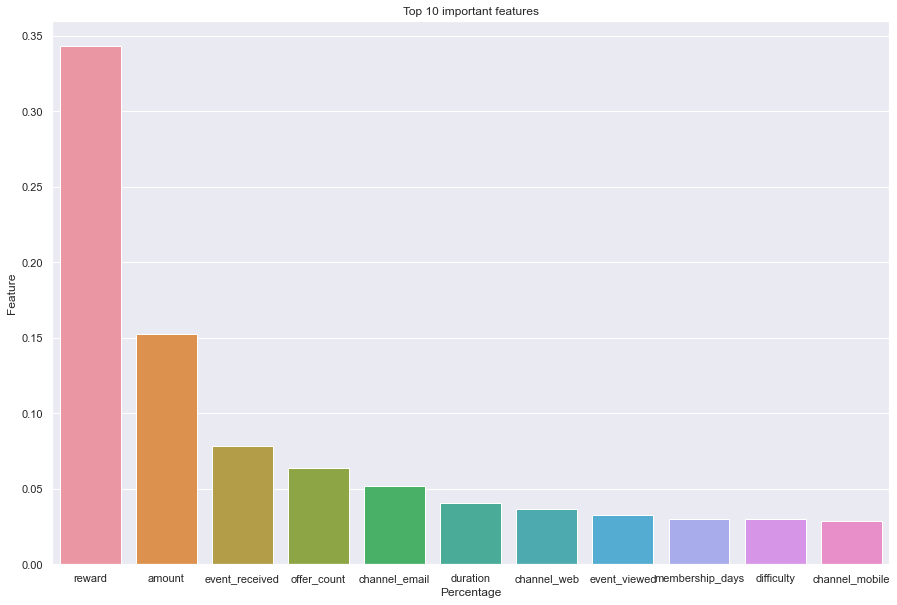

In [73]:
# Plot bar chart of features with their importance
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(
    y=importances_df.loc[0:10,'importances'], 
    x=importances_df.loc[0:10, 'index'], 
    data=importances_df
)
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.title('Top 10 important features')
plt.show()



From the results shown above I can conclude following:

Top 10 features which influence whether the customer will respond to an offer or not after viewing the offer are: 
  
- 'reward' (get money) recieved by the customer is the most important feature, which get more than double score of the seconde importance feature. It represents how much amount as a reward. The reward stimulus works well to push a customer is getting back, response, and complete an offer. 


- 'amount' (spent money) is the second largest feature which represents, which could play a big influence if the customer will complete an offer after viewing the offer. it is about double score of the third importance feature.


- 'event received' which represents, if Starbucks sent the offer to customer and the customer open the offer message  is likely to be responded and complete the offer. Its importance score is bigger than the forth importance feature significantly. 


- 'offer count' which represents, the total number of offer a customer received. from this feature the importance score reducing gradully after it. the importance order could be different depends on variety factors.


- 'channel email' , 'duration' , 'channel web' , 'event reviewed' ,'difficulty', 'membership days'  play similar roles  to influence complete result
  

## 5.3 Predict test data

In [74]:
X_test.head()

,income,membership_days,gender_female,gender_male,gender_other,amount,reward,offer_count,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,age_17_40,age_40_60,age_60_80,myear_2013,myear_2014,myear_2015,myear_2016,myear_2017,myear_2018,mdays_1192_1500,mdays_1500_2000
4588,0.488889,0.681843,0.0,1.0,0.0,0.018338,0.000000,0.117647,0.2,0.166667,0.194444,0.166667,0.428571,0.117647,0.166667,0.000000,0.166667,0.111111,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11981,0.255556,0.372463,0.0,1.0,0.0,0.066371,0.309091,0.470588,0.4,0.500000,0.194444,0.416667,0.619048,0.470588,0.500000,0.500000,0.333333,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13935,0.066667,0.193637,1.0,0.0,0.0,0.015970,0.000000,0.411765,0.8,0.500000,0.222222,0.525000,0.535714,0.411765,0.333333,0.333333,0.444444,0.222222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3479,0.522222,0.463522,0.0,1.0,0.0,0.141258,0.327273,0.647059,0.6,0.666667,0.388889,0.462500,0.535714,0.647059,0.500000,0.500000,0.666667,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3647,0.300000,0.320351,0.0,1.0,0.0,0.033095,0.200000,0.411765,0.4,0.333333,0.472222,0.312500,0.464286,0.411765,0.444444,0.444444,0.444444,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [75]:
# # Scale selected features in test data
X_test_scaled= X_test.copy()
for col in X_test:
    X_test_scaled[col] = minmax_scale(X_test[col])

X_test_scaled.head()


,income,membership_days,gender_female,gender_male,gender_other,amount,reward,offer_count,event_received,event_viewed,event_transaction,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,age_17_40,age_40_60,age_60_80,myear_2013,myear_2014,myear_2015,myear_2016,myear_2017,myear_2018,mdays_1192_1500,mdays_1500_2000
4588,0.488889,0.683342,0.0,1.0,0.0,0.018338,0.00,0.0625,0.2,0.166667,0.194444,0.166667,0.428571,0.0625,0.166667,0.000000,0.166667,0.111111,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11981,0.255556,0.373282,0.0,1.0,0.0,0.066371,0.34,0.4375,0.4,0.500000,0.194444,0.416667,0.619048,0.4375,0.500000,0.529412,0.333333,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13935,0.066667,0.194063,1.0,0.0,0.0,0.015970,0.00,0.3750,0.8,0.500000,0.222222,0.525000,0.535714,0.3750,0.333333,0.352941,0.444444,0.222222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3479,0.522222,0.464541,0.0,1.0,0.0,0.141258,0.36,0.6250,0.6,0.666667,0.388889,0.462500,0.535714,0.6250,0.500000,0.529412,0.666667,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3647,0.300000,0.321056,0.0,1.0,0.0,0.033095,0.22,0.3750,0.4,0.333333,0.472222,0.312500,0.464286,0.3750,0.444444,0.470588,0.444444,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [76]:
# Classification of test data using best model trained on train data
predictions = forest_estimator.predict(X_test_scaled).astype(int)
predictions

array([0, 1, 0, ..., 0, 1, 1])

## 5.4 Caculate Confusion Matrix

In [77]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.astype(int), predictions).ravel()

In [78]:
# displaye tn, fp, fn, tp from confusion matrix
print(f"True negatives: {tn}, False postives: {fp}")
print(f"False negatives: {fn}, True postives: {tp}")

True negatives: 1575, False postives: 70
False negatives: 28, True postives: 2032


In [79]:
precision = tp / (tp + fp)
recall    = tp / (fn + tp)
print(f"Precision                ", precision* 100)
print(f"Recall                   ", recall* 100)
print(f"Accuracy                 ", (tp + tn) / (fp + fn + tn + tp)* 100)
print(f"F1-score                 ", 2 * (precision * recall) / (precision + recall) * 100)
print(f"misclassifying acceptance", fn / (fn + tp) * 100)
print(f"misclassifying refusal   ", fp / (fp + tn) * 100)



Precision                 96.6698382492864
Recall                    98.64077669902913
Accuracy                  97.3549257759784
F1-score                  97.6453628063431
misclassifying acceptance 1.3592233009708738
misclassifying refusal    4.25531914893617


The results shows that, the prediction model has 
Precision 96.6% , Recall 98.8%, Accuracy 97.4%, and F1-score 97.7%.
To the customers who may accept an offer, there are 1.36% misclassifying acceptance.
To the customers who may refuse an offer, there are 4.26% misclassifying refusal. 
In this project 

Because misclassifying refusal is about 3 times of misclassifying acceptance, the predictive model is doing well as it has very low chances of missing an customer who may respond an offer than who may ignore. 

In this project, sending offer to a potential customer with high chance of responding is more important than to a person may refuse the offer. That means, even through both higher precision and higher recall are goal we trying to go for,  the higher recall is more meaningful to this project than precision. Therefore, the predictive model would fit the purpose in this project.

# 5. Review and Conclusion

The problem in this project is to build a model that predicts whether a starbucks' customer will respond to an offer. After clean the Problem Definition, the solution has mainly four steps. 

First is Data Loading and Cleaning. I was preprocessing portfolio, profile and transaction datasets, and get several cleaned and verified data. Also did some understanding of cleaned data and show some visilizations.  

Second, Feature Selection and Engineering. In this step I was combined 3 datas sets in to one by join customer_id. To keep more information from transaction dataset, customer events data need to be aggreated.

Third, Normalizing and Engineering Data for Machine Learning. Dummy data and cut data to generate new features, and  remove the features that has less relevent. shuffle the data and split data for train and test.

Last, based on the splitted data I get a quick comparison of f1-score and time used between 4 algorithms by GridSearch. And I chose the best estimator "RandomForestClassifier" to train and predict the splitted data. A confusion matrix was generated to verify the performance my model. 

The estimator `forest_estimator` which I got at end, can fit the purpose of predicting a customer would or not response an stabucks' offer.



# 6 Improvement

First of all, the result looks like pretty good, I can understood the data well before implement any engineering code.
and I plan the project through the conclution from each step and section. That is fallow a methodology called reflection in action.

However, the result is based on several choice of data selection , feature engineering , and algorithm selection. 
Once the dataset changed, for example, some feature was dropped such as `gender_others`, `time`, and `offer_discount`. because they played a low correlation with other features. But in nother dataset , these dropped feature may shows higher weight than current dataset.  In nother dataset, `gender_others` could be higher than `gender_male`, then `gender_male` can be ignored.  The less correlation features can be detected by an algorithm automaticaly , then remove them or choose top N relevent features.

Another improvement is use higher folds in GridSeachCV, than may give better result but running bit logger time. the slower is tolerable, but the result is critial for later Model Building.
